In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Importing the Libraries.
import keras
import os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
#import keras.backend as K
import tensorflow.keras.backend as K
import tensorflow.compat.v1 as tf
from os import listdir
from os.path import isfile, join
import numpy as np
import sys
import os
import shutil
import pandas as pd
from PIL import Image
import cv2
import keras
import glob
from PIL import Image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPool2D
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.models import load_model
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from PIL import ImageFile

In [ ]:
tf.enable_eager_execution()

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Data Augmentation.
DataGenerator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255, brightness_range=[0.2,0.7])

In [ ]:
TestGenerator = ImageDataGenerator(rescale=1./255)

In [ ]:
Grey_TrainingData = DataGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Train/', target_size=(224,224), batch_size=8, color_mode='grayscale')

Found 2015 images belonging to 112 classes.


In [ ]:
Grey_ValidData = TestGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Valid/', target_size=(224,224),batch_size=8, color_mode='grayscale')

Found 112 images belonging to 112 classes.


In [ ]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

In [ ]:
conv_base = InceptionResNetV2(weights = 'imagenet', include_top = False, pooling = 'avg')

219062272/219055592 [==============================] - 2s 0us/step


In [ ]:
for layer in conv_base.layers[:765]:
  layer.trainable = False
for layer in conv_base.layers[765:]:
  layer.trainable = True
for layer in conv_base.layers:
  if isinstance(layer, BatchNormalization):
    layer.trainable = True

In [ ]:
for i, layer in enumerate(conv_base.layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 conv2d False
2 batch_normalization True
3 activation False
4 conv2d_1 False
5 batch_normalization_1 True
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 True
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 True
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 True
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 True
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 True
24 batch_normalization_9 True
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 True
33 batch_normalization_7 True
34 batch_normalization_10 True
35 batch_normalization_11 True
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed_5b False
41 conv2d_15 False
42 batch_normalization_15 True
43 activat

In [ ]:
from keras.layers import Input

In [ ]:
input_tensor = Input(shape=(224,224,1))

In [ ]:
x = Conv2D(3,(3,3), padding='same')(input_tensor)

In [ ]:
x = conv_base(x)

In [ ]:
x = Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
out = Dense(112, activation='softmax')(x)

In [ ]:
model = Model(inputs = input_tensor, outputs = out)

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 224, 224, 3)       30        
_________________________________________________________________
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dense (Dense)                (None, 2048)              3147776   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 112)               229488    
Total params: 57,714,030
Trainable params: 8,236,782
Non-trainable params: 49,477,248
__________________________________

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("/content/drive/My Drive/1-piece/Inception_ResnetV2_GrayScale.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 40,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 40,
                              verbose = 1,
                              min_delta = 0.00001)

callBacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
hist = model.fit_generator(steps_per_epoch=252,generator= Grey_TrainingData, validation_data= Grey_ValidData, validation_steps=14,epochs=150,callbacks=callBacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
252/252 [==============================] - ETA: 0s - loss: 5.5671 - accuracy: 0.0387
Epoch 00001: val_loss improved from inf to 4.30550, saving model to /content/drive/My Drive/1-piece/Inception_ResnetV2_GrayScale.h5
252/252 [==============================] - 1646s 7s/step - loss: 5.5671 - accuracy: 0.0387 - val_loss: 4.3055 - val_accuracy: 0.1250
Epoch 2/150
252/252 [==============================] - ETA: 0s - loss: 4.0440 - accuracy: 0.1270
Epoch 00002: val_loss improved from 4.30550 to 3.72152, saving model to /content/drive/My Drive/1-piece/Inception_ResnetV2_GrayScale.h5
252/252 [==============================] - 98s 388ms/step - loss: 4.0440 - accuracy: 0.1270 - val_loss: 3.7215 - val_accuracy: 0.2143
Epoch 3/150
252/252 [==============================] - ETA: 0s - loss: 3.2977 - accuracy: 0.2069
Epoch 00003: val_loss improved from 3.72152 to 3.58306, saving model to /content/drive/My Drive/1-

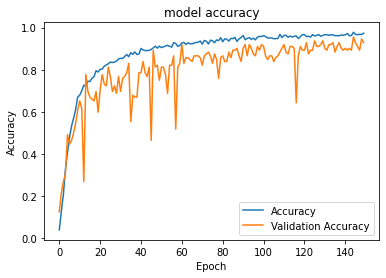

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

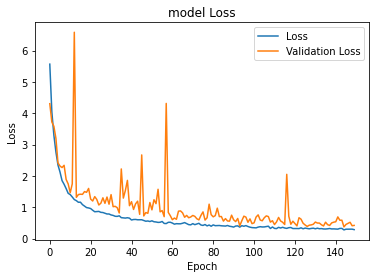

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [ ]:
GreyTestData = TestGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Test/', target_size=(224,224), batch_size = 8, shuffle = False, color_mode='grayscale')

Found 112 images belonging to 112 classes.


In [ ]:
Grey_predict = model.predict(GreyTestData)

In [ ]:
Grey_predict_classes = np.argmax(Grey_predict, axis=1)

In [ ]:
Grey_predict_classes

array([  0,   1,   1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        14,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        29,  27,  17,  29,  30,  31,  32,  33,  32,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  52,  46,  48,  48,  49,  50,  51,
        52,  53,  54,  54,  56,  57,  58,  59,  60,  61,  51,  63,  64,
        65,  66,  67,  68,  69,  70,  71, 110,  73,  74,  75,  76,  77,
        75,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111])

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [ ]:
Grey_accuracy = accuracy_score(GreyTestData.classes, Grey_predict_classes)
print("Grey Accuracy: ", Grey_accuracy)

Grey Accuracy:  0.9017857142857143


In [ ]:
Grey_precision = precision_score(GreyTestData.classes, Grey_predict_classes,average="weighted")
print("Grey Precision: ", Grey_precision)

Grey Precision:  0.8526785714285714


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Grey_recall = recall_score(GreyTestData.classes, Grey_predict_classes, average="weighted")
print("Grey Recall:", Grey_recall)

Grey Recall: 0.9017857142857143


In [ ]:
Grey_f1_score = f1_score(GreyTestData.classes, Grey_predict_classes, average="weighted")
print("F1 score for Grey: ", Grey_f1_score)

F1 score for Grey:  0.8690476190476192


In [ ]:
Colour_TrainingData =  DataGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Train/', target_size=(224,224), batch_size=8)

Found 2015 images belonging to 112 classes.


In [ ]:
Colour_ValidData =  DataGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Valid/', target_size=(224,224), batch_size=8)

Found 112 images belonging to 112 classes.


In [ ]:
conv_base_colour = InceptionResNetV2(weights = 'imagenet', include_top = False, pooling = 'avg')

In [ ]:
for layer in conv_base.layers[:765]:
  layer.trainable = False
for layer in conv_base.layers[765:]:
  layer.trainable = True
for layer in conv_base.layers:
  if isinstance(layer, BatchNormalization):
    layer.trainable = True

In [ ]:
for i, layer in enumerate(conv_base.layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 conv2d False
2 batch_normalization True
3 activation False
4 conv2d_1 False
5 batch_normalization_1 True
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 True
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 True
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 True
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 True
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 True
24 batch_normalization_9 True
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 True
33 batch_normalization_7 True
34 batch_normalization_10 True
35 batch_normalization_11 True
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed_5b False
41 conv2d_15 False
42 batch_normalization_15 True
43 activat

In [ ]:
from keras.layers import Input

In [ ]:
input_tensor = Input(shape=(224,224,3))

In [ ]:
x = conv_base_colour(input_tensor)

In [ ]:
x = Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
out = Dense(112, activation='softmax')(x)

In [ ]:
model_colour = Model(inputs = input_tensor, outputs = out)

In [ ]:
model_colour.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              3147776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 112)               229488    
Total params: 57,714,000
Trainable params: 57,653,456
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
model_colour.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("/content/drive/My Drive/1-piece/Colour_Inception_ResnetV2.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 40,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 40,
                              verbose = 1,
                              min_delta = 0.00001)

callBacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
hist = model_colour.fit_generator(steps_per_epoch=252,generator= Colour_TrainingData, validation_data= Colour_ValidData, validation_steps=14,epochs=150,callbacks=callBacks)

Epoch 1/150
252/252 [==============================] - ETA: 0s - loss: 5.6678 - accuracy: 0.0159
Epoch 00001: val_loss improved from inf to 9.67970, saving model to /content/drive/My Drive/1-piece/Colour_Inception_ResnetV2.h5
252/252 [==============================] - 96s 381ms/step - loss: 5.6678 - accuracy: 0.0159 - val_loss: 9.6797 - val_accuracy: 0.0357
Epoch 2/150
252/252 [==============================] - ETA: 0s - loss: 4.4888 - accuracy: 0.0387
Epoch 00002: val_loss did not improve from 9.67970
252/252 [==============================] - 89s 352ms/step - loss: 4.4888 - accuracy: 0.0387 - val_loss: 22.7229 - val_accuracy: 0.0357
Epoch 3/150
252/252 [==============================] - ETA: 0s - loss: 3.9222 - accuracy: 0.0809
Epoch 00003: val_loss improved from 9.67970 to 3.22145, saving model to /content/drive/My Drive/1-piece/Colour_Inception_ResnetV2.h5
252/252 [==============================] - 97s 386ms/step - loss: 3.9222 - accuracy: 0.0809 - val_loss: 3.2214 - val_accuracy: 

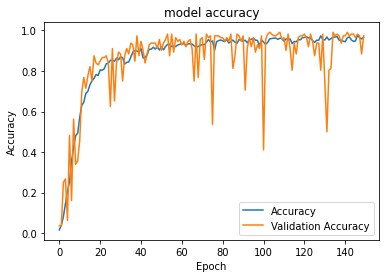

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

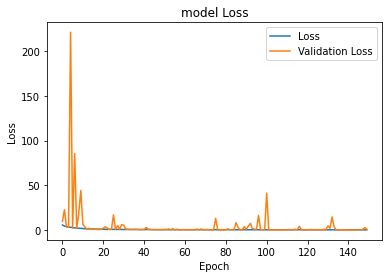

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [ ]:
Colour_TestData = TestGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Test/', target_size=(224,224), batch_size = 8, shuffle = False)

Found 112 images belonging to 112 classes.


In [ ]:
Colour_predict = model_colour.predict(Colour_TestData)

In [ ]:
Colour_predict_classes = np.argmax(Colour_predict, axis=1)

In [ ]:
Colour_predict_classes

array([  0,   1,  26,  15,   4,   5,   6,  11,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  15,  21,  11,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  15,  35,  36,  37,  11,
        39,  40,  41,  42,  43,  44,  15,  46,  47,  48,  49,  50,  51,
        52,  53,  15,  55, 109,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  72,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111])

In [ ]:
Colour_accuracy = accuracy_score(Colour_TestData.classes, Colour_predict_classes)
print("Colour Accuracy: ", Colour_accuracy)

Colour Accuracy:  0.9017857142857143


In [ ]:
Colour_precision = precision_score(Colour_TestData.classes, Colour_predict_classes,average="weighted")
print("Colour Precision: ", Colour_precision)

Colour Precision:  0.8742559523809524


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Colour_recall = recall_score(Colour_TestData.classes, Colour_predict_classes, average="weighted")
print("Colour Recall:", Colour_recall)

Colour Recall: 0.9017857142857143


In [ ]:
Colour_f1_score = f1_score(Colour_TestData.classes, Colour_predict_classes, average="weighted")
print("F1 score for colour: ", Colour_f1_score)

F1 score for colour:  0.8811224489795918


In [ ]:
Final = 0.6* Colour_predict + 0.4* Grey_predict

In [ ]:
Final_Predict_classes = np.argmax(Final, axis=1)

In [ ]:
Final_Predict_classes

array([  0,   1,   1,  15,   4,   5,   6,  11,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  15,  21,  11,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  15,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  15,  46,  47,  48,  49,  50,  51,
        52,  53,  15,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  72,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111])

In [ ]:
Final_accuracy = accuracy_score(Colour_TestData.classes, Final_Predict_classes)
print("Colour Accuracy: ", Final_accuracy)

Colour Accuracy:  0.9196428571428571


In [ ]:
Final_precision = precision_score(Colour_TestData.classes, Final_Predict_classes,average="weighted")
print("Colour Precision: ", Final_precision)

Colour Precision:  0.8973214285714286


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Final_recall = recall_score(Colour_TestData.classes, Final_Predict_classes, average="weighted")
print("Colour Recall:", Final_recall)

Colour Recall: 0.9196428571428571


In [ ]:
Final_f1_score = f1_score(Colour_TestData.classes, Final_Predict_classes, average="weighted")
print("F1 score for colour: ", Final_f1_score)

F1 score for colour:  0.9028486394557823


In [ ]:
Second_Final = 0.5* Colour_predict + 0.5 * Grey_predict

In [ ]:
Second_predict_classes = np.argmax(Second_Final, axis=1)

In [ ]:
Second_predict_classes

array([  0,   1,   1,  15,   4,   5,   6,  11,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  15,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  15,  46,  47,  48,  49,  50,  51,
        52,  53,  15,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111])

In [ ]:
Second_Final_accuracy = accuracy_score(Colour_TestData.classes, Second_predict_classes)
Second_Final_accuracy

0.9464285714285714